In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss
from scipy.io import arff

In [2]:
data = arff.loadarff('Dataset/PhishingData.arff')
df = pd.DataFrame(data[0])
total_eff = len(df)
df.describe()

,SFH,popUpWidnow,SSLfinal_State,Request_URL,URL_of_Anchor,web_traffic,URL_Length,age_of_domain,having_IP_Address,Result
count,1353,1353,1353,1353,1353,1353,1353,1353,1353,1353
unique,3,3,3,3,3,3,3,2,2,3
top,b'1',b'0',b'1',b'-1',b'-1',b'0',b'0',b'1',b'0',b'-1'
freq,767,639,751,617,610,473,563,825,1198,702


In [3]:
aggs = dict()
for var in df.columns[:-1]:
    var_results = df[[var, 'Result']]
    var_results['Frequency']=1
    var_results_freqs = var_results.groupby([var, 'Result'], as_index=False).agg({'Frequency': 'sum'})
    aggs[var] = var_results_freqs

/tmp/ipykernel_69569/3813648546.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  var_results['Frequency']=1


In [4]:
def generate_result_freqs(result, all_results_freqs, var, labels):
    merge = labels.merge(all_results_freqs[all_results_freqs.Result==result], on=var, how='left')
    return (100*merge.Frequency.fillna(0)/total_eff).apply(lambda x: round(x,2))

In [5]:
def plot_dist_var_per_result():
    fig, ax = plt.subplots(3,3, figsize=(15, 15))
    for i, var in enumerate(aggs):
        var_results_freqs = aggs[var]
        labels = pd.DataFrame(var_results_freqs[var].unique(), columns=[var])
        result_minus_one = generate_result_freqs(b'-1', var_results_freqs, var, labels)
        result_zero = generate_result_freqs(b'0', var_results_freqs, var, labels)
        result_plus_one = generate_result_freqs(b'1', var_results_freqs, var, labels)

        x = np.arange(len(labels))
        width = 0.6
        current_ax = ax[int(i/3)][i%3]
        rects1 = current_ax.bar(x - width/3, result_minus_one, width/3, label='Result=-1')
        rects2 = current_ax.bar(x, result_zero, width/3, label='Result=0')
        rects3 = current_ax.bar(x + width/3, result_plus_one, width/3, label='Result=1')

        current_ax.set_ylabel('Frequency (%)')
        current_ax.set_xlabel(var)
        current_ax.set_xticks(x)
        current_ax.set_xticklabels(labels.apply(lambda x: x[0], axis=1))
        current_ax.legend()

        current_ax.bar_label(rects1, padding=1)
        current_ax.bar_label(rects2, padding=1)
        current_ax.bar_label(rects3, padding=1)

        fig.tight_layout()
    #plt.savefig("results_dist_per_var.jpg")
    plt.show()

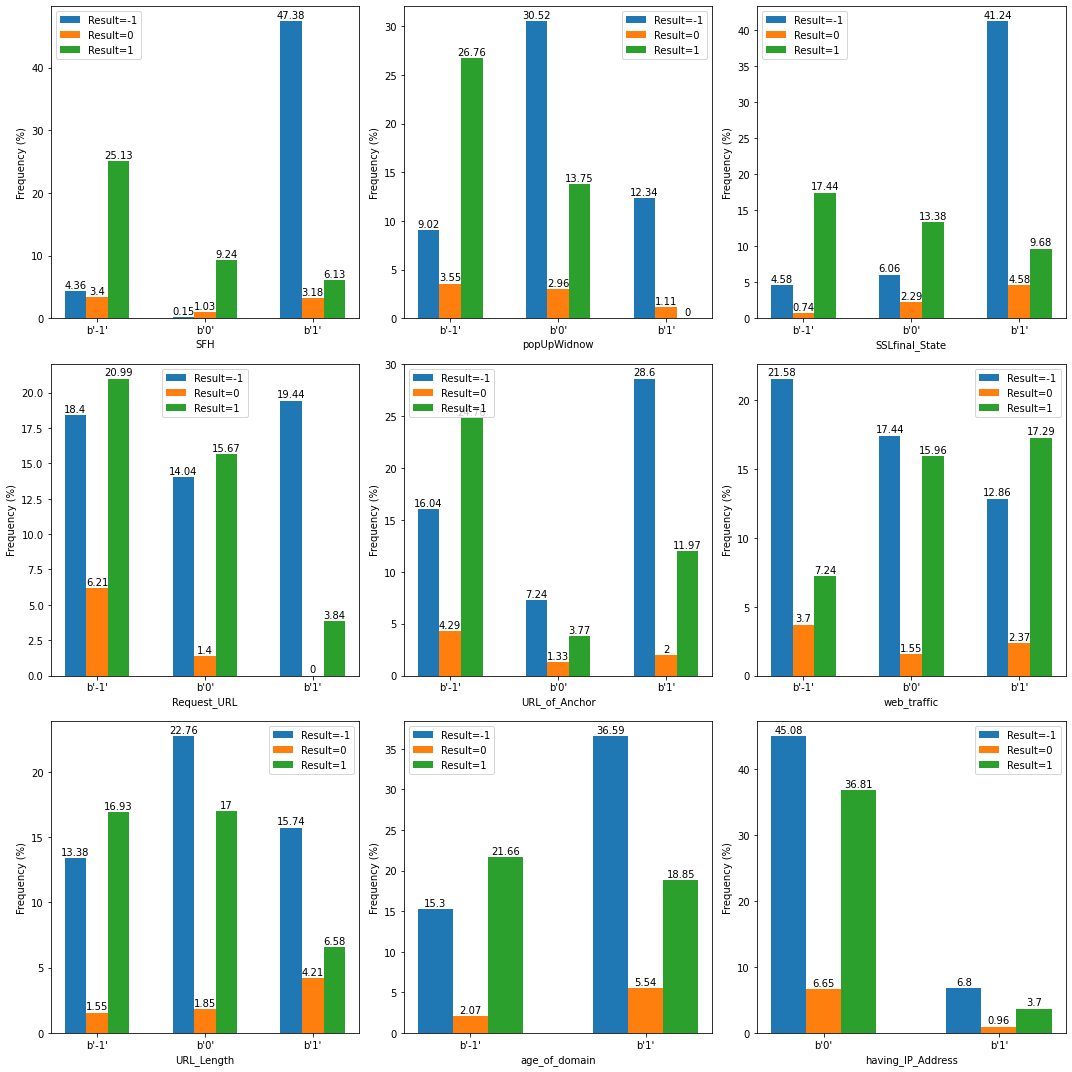

CPU times: user 4.05 s, sys: 226 ms, total: 4.28 s
Wall time: 4.47 s


In [6]:
%%time
plot_dist_var_per_result()

In [7]:
def plot_dist_result_per_var():
    fig, ax = plt.subplots(3,3, figsize=(15, 15))
    for i, var in enumerate(aggs):
        var_results_freqs = aggs[var]
        labels = pd.DataFrame(var_results_freqs['Result'].unique(), columns=['Result'])

        x = np.arange(len(labels))
        width = 0.6
        current_ax = ax[int(i/3)][i%3]

        tmp = len(var_results_freqs[var].unique())
        for i, var_value in enumerate(var_results_freqs[var].unique(), -1*int(tmp/2)):
            result = np.array([])
            if len(var_results_freqs[var_results_freqs[var] ==  var_value][var_results_freqs['Result']==b'-1'].Frequency) == 0:
                result = np.append(result, 0)
            else:
                result = np.append(result, var_results_freqs[var_results_freqs[var] ==  var_value][var_results_freqs['Result']==b'-1'].Frequency.iloc[0])
            if len(var_results_freqs[var_results_freqs[var] ==  var_value][var_results_freqs['Result']==b'0'].Frequency) == 0:
                result = np.append(result, 0)
            else:
                result = np.append(result, var_results_freqs[var_results_freqs[var] ==  var_value][var_results_freqs['Result']==b'0'].Frequency.iloc[0])
            if len(var_results_freqs[var_results_freqs[var] ==  var_value][var_results_freqs['Result']==b'1'].Frequency) == 0:
                result = np.append(result, 0)
            else:
                result = np.append(result, var_results_freqs[var_results_freqs[var] ==  var_value][var_results_freqs['Result']==b'1'].Frequency.iloc[0])


            rects1 = current_ax.bar(x + i*width/tmp + (width/tmp/2 if tmp%2==0 else 0), (100*pd.Series(result)/total_eff).apply(lambda x: round(x,2)), width/tmp, label='{}={}'.format(var, var_value))

            current_ax.bar_label(rects1, padding=1)
        current_ax.set_ylabel('Frequency (%)')
        current_ax.set_xlabel('Result')
        current_ax.set_xticks(x)
        current_ax.set_xticklabels(labels.apply(lambda x: x[0], axis=1))
        current_ax.legend()
        fig.tight_layout()
    #plt.savefig("results_dist_per_var.jpg")
    plt.show()

/tmp/ipykernel_262423/3296117122.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if len(var_results_freqs[var_results_freqs[var] ==  var_value][var_results_freqs['Result']==b'-1'].Frequency) == 0:
/tmp/ipykernel_262423/3296117122.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = np.append(result, var_results_freqs[var_results_freqs[var] ==  var_value][var_results_freqs['Result']==b'-1'].Frequency.iloc[0])
/tmp/ipykernel_262423/3296117122.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if len(var_results_freqs[var_results_freqs[var] ==  var_value][var_results_freqs['Result']==b'0'].Frequency) == 0:
/tmp/ipykernel_262423/3296117122.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = np.append(result, var_results_freqs[var_results_freqs[var] ==  var_value][var_results_freqs['Result']==b'0'].Frequency.iloc[0])
/tmp/ipykernel_262423/

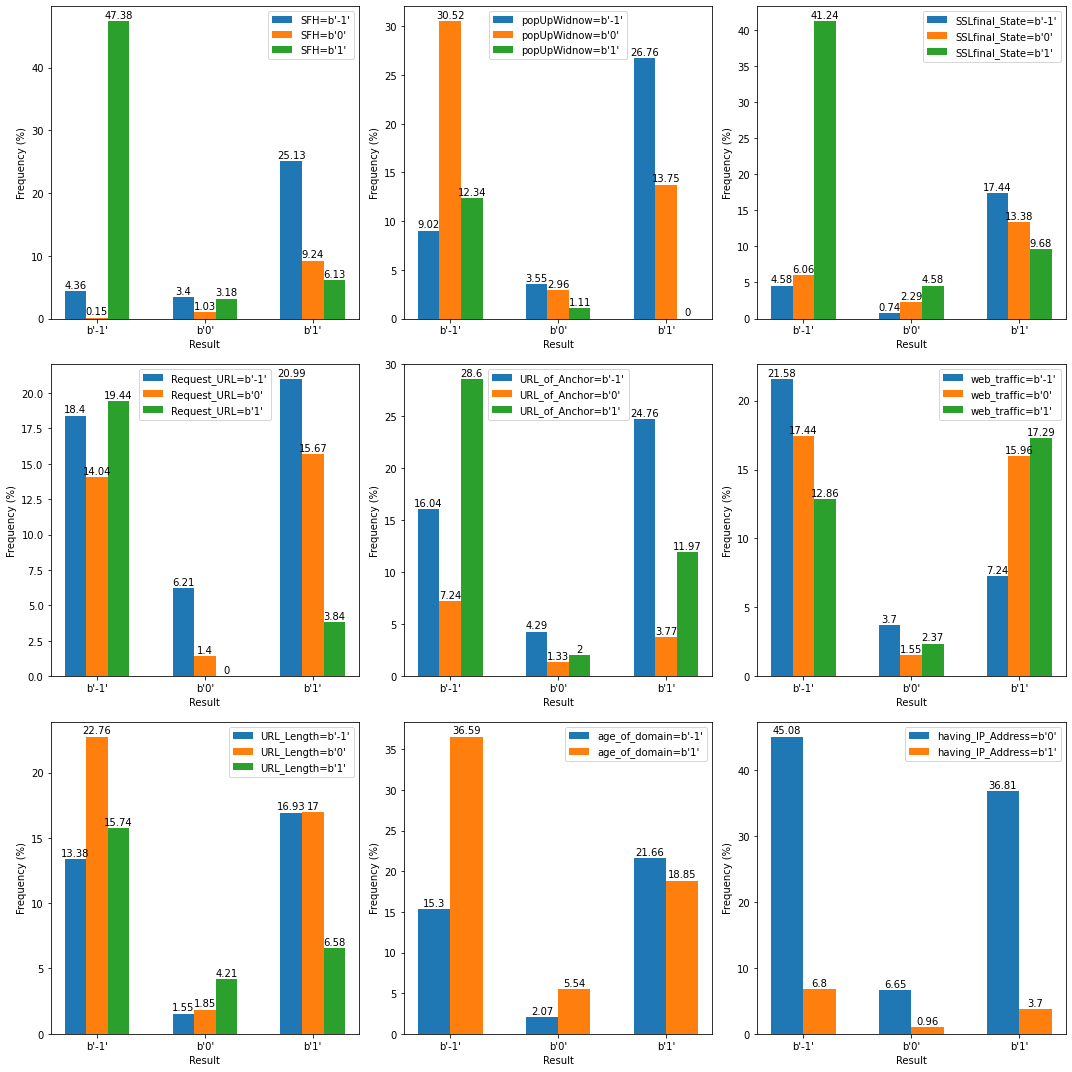

CPU times: user 3.44 s, sys: 203 ms, total: 3.64 s
Wall time: 3.35 s


In [14]:
%%time
plot_dist_result_per_var()

In [8]:
def plot_dist_result():
    fig, ax = plt.subplots(figsize=(7, 7))
    results_df = df[['Result']]
    results_df['Frequency']=1
    results_freqs = results_df.groupby(['Result'], as_index=False).agg({'Frequency': 'sum'})
    
    labels = results_freqs.Result
    width = 0.4
    x = np.arange(len(labels))
    rect = ax.bar(x, (100*results_freqs.Frequency/total_eff).apply(lambda x: round(x,2)))
    
    ax.set_ylabel('Frequency (%)')
    ax.set_xlabel('Result')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)

    ax.bar_label(rect, padding=1)

    fig.tight_layout()
    #plt.savefig("results_dist_per_var.jpg")
    plt.show()

/tmp/ipykernel_69569/3168906068.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df['Frequency']=1


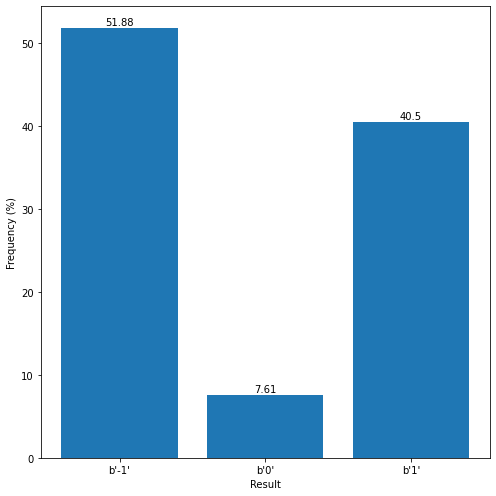

In [13]:
plot_dist_result()

# Interprétation des distributions

## Distribution de la variable ***Result***
L'on observe dans la distribution de la variable à prédire ***Result*** que la classe Result = '0' est sous représentée, avec une proportion de 7.61%.<br>
Nous devons donc préter une attention particulière à cette classe lors de la construction de notre modèle de classification. Car l'on risquerait d'avoir un modèle ayant une bonne performance globale (possiblement 90%~92%), mais qui se plante complètement sur cette classe.

In [14]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    obs = confusion_matrix.sum().sum()
    mini = min(confusion_matrix.shape)-1
    return np.sqrt(chi2/(obs*mini))
    """
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))
    """

In [15]:
def corr_matrix():
    corr = pd.DataFrame(index=df.columns, columns=df.columns)
    for i, var1 in enumerate(df.columns):
        for j in np.arange(i, len(df.columns)) :
            var2 = df.columns[j]
            if i==j:
                corr[var1][var2] = 1.0
            else:
                corr[var1][var2] = corr[var2][var1] = round(cramers_v(df[var1], df[var2]), 2)
    return corr

In [16]:
def plot_corr_matrix():
    fig, ax = plt.subplots(figsize=(10, 10))
    corr = corr_matrix()
    im = ax.imshow(np.array(corr.values, dtype=float))

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels(labels=df.columns)
    ax.set_yticks(np.arange(len(df.columns)))
    ax.set_yticklabels(labels=df.columns)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(df.columns)):
        for j in range(len(df.columns)):
            text = ax.text(j, i, corr.iloc[i, j], ha="center", va="center", color="w")

    ax.set_title("Correlation")
    fig.tight_layout()
    plt.show()

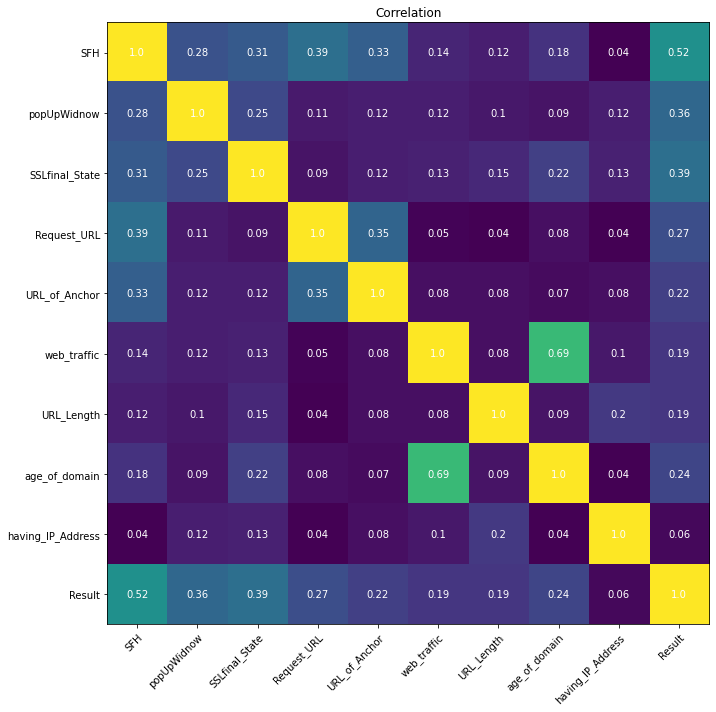

CPU times: user 1.53 s, sys: 75.9 ms, total: 1.6 s
Wall time: 1.65 s


In [17]:
%%time
plot_corr_matrix()

In [ ]:
chi_square_scores = dict()
for var in df.columns[:-1]:
    confusion_matrix = pd.crosstab(df[var], df.Result)
    chi2 = ss.chi2_contingency(confusion_matrix)
    chi_square_scores[var] = chi2
chi_square_scores

**Remarque** : Penser à faire un histogramme pour illustrer la distribution des statistiques de Chi 2 calculées précédemment.

# Interprétation des correlations

### Entre variables prédictives
Entre variables prédictives, l'on n'observe pas de coéfficient de corrélation se rapprochant de 1. Nos variables explicatives ne sont donc pas fortement liées.

### Entre variables prédictives et variable à prédire
On remarque que la variable ***having_IP_Address*** a une correlation très faible avec la variable à prédire ***Result***.
En éffectuant un test de Chi 2 sur l'hypothèse d'indépendance de ces deux variables, l'on constate que la statistique de Chi 2 vaut 4.95 (Largement plus faible que les autres qui sont de l'ordre de la centaine), pour une P-Value de 0.08 qui est supérieure au seuil habituel de 0.05.<br>
>L'on ne peut donc pas rejéter l'hypothèse selon laquelle ***having_IP_Address*** et ***Result*** sont indépendantes.


Il ne serait donc probablement pas intéressant d'inclure la variable ***having_IP_Address*** dans un modèle de prédiction de ***Result***. L'on pourra vérifier cette assertion en observant l'impact de la variable ***having_IP_Address*** sur les modèles de prédiction de ***Result*** que nous ferons par la suite.